In [2]:
import tensorflow as tf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2, time

In [3]:
covid_path = 'dataset/covid_dataset.csv'
covid_image_path = 'dataset/covid_adjusted/'

normal_path = 'dataset/normal_xray_dataset.csv'
normal_image_path = 'dataset/normal_dataset/'

covid_df = pd.read_csv(covid_path, usecols=['filename', 'finding'])
normal_df = pd.read_csv(normal_path, usecols=['filename', 'finding'])

In [4]:
print(normal_df.shape)
print(covid_df.shape)

(8583, 2)
(92, 2)


In [5]:
normal_df = normal_df.head(99)

In [6]:
print(normal_df.shape)
print(covid_df.shape)

(99, 2)
(92, 2)


In [7]:
covid_images = []
covid_labels = []
normal_images = []
normal_labels = []

In [8]:
for index, row in covid_df.iterrows():
  filename = row['filename']
  label = row['finding']
  path = covid_image_path + filename

  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
  covid_images.append(image)
  covid_labels.append(label)
print(len(covid_images), len(covid_labels))

92 92


In [9]:
for index, row in normal_df.iterrows():
  filename = row['filename']
  label = row['finding']
  path = normal_image_path + filename

  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
  normal_images.append(image)
  normal_labels.append(label)
print(len(normal_images), len(normal_labels))

99 99


In [10]:
covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255

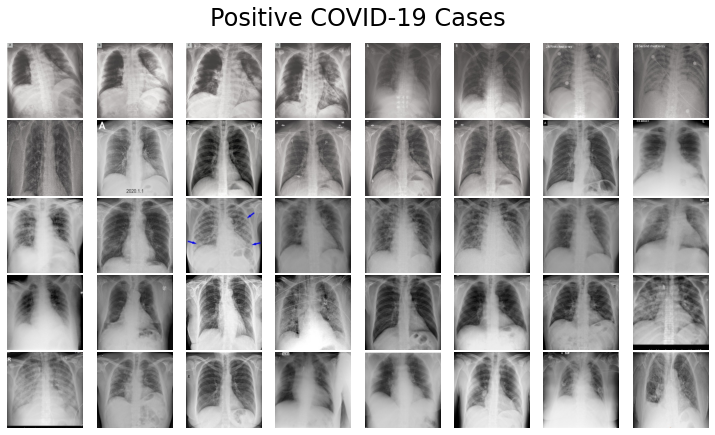

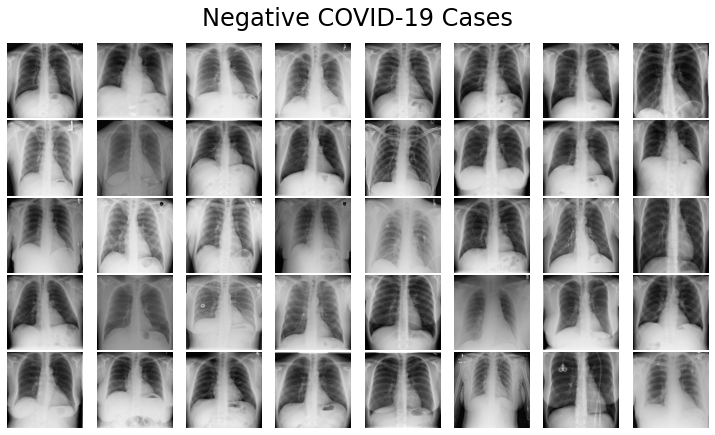

In [11]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor = (1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images(covid_images, 'Positive COVID-19 Cases')
plot_images(normal_images, 'Negative COVID-19 Cases')

In [12]:
from sklearn.model_selection import train_test_split

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2, random_state = 0)

normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(normal_images, normal_labels, test_size=0.2, random_state = 0)

X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

In [13]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
it = datagen.flow(X_train, y_train, batch_size = 32)

In [4]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import pickle

In [23]:
deepModel = Xception(weights = 'imagenet', 
                       include_top = False,
                       pooling = 'max',
                       input_tensor = Input(shape = (224, 224, 3))
                      )
for layer in deepModel.layers:
    layer.trainable = False

In [24]:
outputs = deepModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

In [25]:
model = Model(inputs = deepModel.input, outputs = outputs)

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [27]:
history = model.fit(it, 
                    validation_data = (X_test, y_test), 
                    validation_steps = len(X_test) / 32, 
                    steps_per_epoch = len(X_train) / 32, 
                    epochs = 800,
                   )

Epoch 1/800
5/4 [===============================] - 21s 4s/step - loss: 1.2377 - accuracy: 0.5000 - val_loss: 0.7621 - val_accuracy: 0.5641
Epoch 2/800
5/4 [===============================] - 20s 4s/step - loss: 1.1628 - accuracy: 0.5461 - val_loss: 0.5535 - val_accuracy: 0.6667
Epoch 3/800
5/4 [===============================] - 20s 4s/step - loss: 0.8740 - accuracy: 0.6776 - val_loss: 0.5267 - val_accuracy: 0.6923
Epoch 4/800
5/4 [===============================] - 19s 4s/step - loss: 0.7677 - accuracy: 0.6645 - val_loss: 0.4826 - val_accuracy: 0.7692
Epoch 5/800
5/4 [===============================] - 20s 4s/step - loss: 0.9114 - accuracy: 0.6053 - val_loss: 0.4353 - val_accuracy: 0.8205
Epoch 6/800
5/4 [===============================] - 21s 4s/step - loss: 0.7389 - accuracy: 0.6711 - val_loss: 0.4543 - val_accuracy: 0.8205
Epoch 7/800
5/4 [===============================] - 19s 4s/step - loss: 0.8330 - accuracy: 0.6711 - val_loss: 0.3779 - val_accuracy: 0.7949
Epoch 8/800
5/4 [===

5/4 [===============================] - 19s 4s/step - loss: 0.3340 - accuracy: 0.8618 - val_loss: 0.2777 - val_accuracy: 0.8462
Epoch 118/800
5/4 [===============================] - 19s 4s/step - loss: 0.4280 - accuracy: 0.8026 - val_loss: 0.2061 - val_accuracy: 0.8974
Epoch 119/800
5/4 [===============================] - 19s 4s/step - loss: 0.4060 - accuracy: 0.8289 - val_loss: 0.2049 - val_accuracy: 0.9487
Epoch 120/800
5/4 [===============================] - 19s 4s/step - loss: 0.3537 - accuracy: 0.8487 - val_loss: 0.2722 - val_accuracy: 0.8462
Epoch 121/800
5/4 [===============================] - 20s 4s/step - loss: 0.2958 - accuracy: 0.8882 - val_loss: 0.2044 - val_accuracy: 0.8974
Epoch 122/800
5/4 [===============================] - 20s 4s/step - loss: 0.3231 - accuracy: 0.8750 - val_loss: 0.2268 - val_accuracy: 0.8974
Epoch 123/800
5/4 [===============================] - 20s 4s/step - loss: 0.4017 - accuracy: 0.8224 - val_loss: 0.1907 - val_accuracy: 0.8974
Epoch 124/800
5/4 [=

Epoch 175/800
5/4 [===============================] - 19s 4s/step - loss: 0.2170 - accuracy: 0.9013 - val_loss: 0.1887 - val_accuracy: 0.9487
Epoch 176/800
5/4 [===============================] - 19s 4s/step - loss: 0.2921 - accuracy: 0.8553 - val_loss: 0.2226 - val_accuracy: 0.8718
Epoch 177/800
5/4 [===============================] - 20s 4s/step - loss: 0.2844 - accuracy: 0.8882 - val_loss: 0.1787 - val_accuracy: 0.9487
Epoch 178/800
5/4 [===============================] - 20s 4s/step - loss: 0.3503 - accuracy: 0.8684 - val_loss: 0.1685 - val_accuracy: 0.9487
Epoch 179/800
5/4 [===============================] - 19s 4s/step - loss: 0.2933 - accuracy: 0.8816 - val_loss: 0.1954 - val_accuracy: 0.9231
Epoch 180/800
5/4 [===============================] - 19s 4s/step - loss: 0.2559 - accuracy: 0.8487 - val_loss: 0.1629 - val_accuracy: 0.9487
Epoch 181/800
5/4 [===============================] - 20s 4s/step - loss: 0.2691 - accuracy: 0.8553 - val_loss: 0.1710 - val_accuracy: 0.9487
Epoch 

Epoch 233/800
5/4 [===============================] - 19s 4s/step - loss: 0.2689 - accuracy: 0.8618 - val_loss: 0.2247 - val_accuracy: 0.8718
Epoch 234/800
5/4 [===============================] - 19s 4s/step - loss: 0.2719 - accuracy: 0.8882 - val_loss: 0.2238 - val_accuracy: 0.8974
Epoch 235/800
5/4 [===============================] - 20s 4s/step - loss: 0.3200 - accuracy: 0.8750 - val_loss: 0.1976 - val_accuracy: 0.9487
Epoch 236/800
5/4 [===============================] - 19s 4s/step - loss: 0.3275 - accuracy: 0.8684 - val_loss: 0.2163 - val_accuracy: 0.9231
Epoch 237/800
5/4 [===============================] - 19s 4s/step - loss: 0.3647 - accuracy: 0.8553 - val_loss: 0.1963 - val_accuracy: 0.9487
Epoch 238/800
5/4 [===============================] - 20s 4s/step - loss: 0.4057 - accuracy: 0.8289 - val_loss: 0.2183 - val_accuracy: 0.9231
Epoch 239/800
5/4 [===============================] - 19s 4s/step - loss: 0.3311 - accuracy: 0.8289 - val_loss: 0.2293 - val_accuracy: 0.8974
Epoch 

Epoch 291/800
5/4 [===============================] - 19s 4s/step - loss: 0.3325 - accuracy: 0.8487 - val_loss: 0.1765 - val_accuracy: 0.8974
Epoch 292/800
5/4 [===============================] - 19s 4s/step - loss: 0.2303 - accuracy: 0.9211 - val_loss: 0.2238 - val_accuracy: 0.8974
Epoch 293/800
5/4 [===============================] - 20s 4s/step - loss: 0.2836 - accuracy: 0.8816 - val_loss: 0.1784 - val_accuracy: 0.8974
Epoch 294/800
5/4 [===============================] - 19s 4s/step - loss: 0.3941 - accuracy: 0.8355 - val_loss: 0.1762 - val_accuracy: 0.9231
Epoch 295/800
5/4 [===============================] - 19s 4s/step - loss: 0.3171 - accuracy: 0.8750 - val_loss: 0.1714 - val_accuracy: 0.9231
Epoch 296/800
5/4 [===============================] - 19s 4s/step - loss: 0.3144 - accuracy: 0.8618 - val_loss: 0.1902 - val_accuracy: 0.9231
Epoch 297/800
5/4 [===============================] - 19s 4s/step - loss: 0.3312 - accuracy: 0.8355 - val_loss: 0.1889 - val_accuracy: 0.9231
Epoch 

Epoch 349/800
5/4 [===============================] - 19s 4s/step - loss: 0.4039 - accuracy: 0.8158 - val_loss: 0.1751 - val_accuracy: 0.9487
Epoch 350/800
5/4 [===============================] - 20s 4s/step - loss: 0.3231 - accuracy: 0.8750 - val_loss: 0.1729 - val_accuracy: 0.9744
Epoch 351/800
5/4 [===============================] - 19s 4s/step - loss: 0.3276 - accuracy: 0.8750 - val_loss: 0.2248 - val_accuracy: 0.8718
Epoch 352/800
5/4 [===============================] - 19s 4s/step - loss: 0.2998 - accuracy: 0.8421 - val_loss: 0.1675 - val_accuracy: 0.9231
Epoch 353/800
5/4 [===============================] - 19s 4s/step - loss: 0.2608 - accuracy: 0.9013 - val_loss: 0.1711 - val_accuracy: 0.9231
Epoch 354/800
5/4 [===============================] - 19s 4s/step - loss: 0.1913 - accuracy: 0.9145 - val_loss: 0.1778 - val_accuracy: 0.8974
Epoch 355/800
5/4 [===============================] - 19s 4s/step - loss: 0.3918 - accuracy: 0.8553 - val_loss: 0.1863 - val_accuracy: 0.8974
Epoch 

Epoch 407/800
5/4 [===============================] - 19s 4s/step - loss: 0.3384 - accuracy: 0.8816 - val_loss: 0.2170 - val_accuracy: 0.8974
Epoch 408/800
5/4 [===============================] - 19s 4s/step - loss: 0.3099 - accuracy: 0.8618 - val_loss: 0.2701 - val_accuracy: 0.8718
Epoch 409/800
5/4 [===============================] - 19s 4s/step - loss: 0.2246 - accuracy: 0.9211 - val_loss: 0.2035 - val_accuracy: 0.9231
Epoch 410/800
5/4 [===============================] - 19s 4s/step - loss: 0.4214 - accuracy: 0.8224 - val_loss: 0.2445 - val_accuracy: 0.8718
Epoch 411/800
5/4 [===============================] - 19s 4s/step - loss: 0.2860 - accuracy: 0.8947 - val_loss: 0.2463 - val_accuracy: 0.8718
Epoch 412/800
5/4 [===============================] - 20s 4s/step - loss: 0.2698 - accuracy: 0.8816 - val_loss: 0.2007 - val_accuracy: 0.8974
Epoch 413/800
5/4 [===============================] - 20s 4s/step - loss: 0.3335 - accuracy: 0.8618 - val_loss: 0.2482 - val_accuracy: 0.8718
Epoch 

Epoch 465/800
5/4 [===============================] - 19s 4s/step - loss: 0.3044 - accuracy: 0.8487 - val_loss: 0.1886 - val_accuracy: 0.8974
Epoch 466/800
5/4 [===============================] - 19s 4s/step - loss: 0.2787 - accuracy: 0.9079 - val_loss: 0.2861 - val_accuracy: 0.8462
Epoch 467/800
5/4 [===============================] - 19s 4s/step - loss: 0.2499 - accuracy: 0.9079 - val_loss: 0.2081 - val_accuracy: 0.9231
Epoch 468/800
5/4 [===============================] - 19s 4s/step - loss: 0.2898 - accuracy: 0.8816 - val_loss: 0.2106 - val_accuracy: 0.8974
Epoch 469/800
5/4 [===============================] - 19s 4s/step - loss: 0.3822 - accuracy: 0.8684 - val_loss: 0.3302 - val_accuracy: 0.8205
Epoch 470/800
5/4 [===============================] - 19s 4s/step - loss: 0.4994 - accuracy: 0.8224 - val_loss: 0.1976 - val_accuracy: 0.9231
Epoch 471/800
5/4 [===============================] - 20s 4s/step - loss: 0.5032 - accuracy: 0.8158 - val_loss: 0.2073 - val_accuracy: 0.9231
Epoch 

Epoch 523/800
5/4 [===============================] - 19s 4s/step - loss: 0.2278 - accuracy: 0.9276 - val_loss: 0.2763 - val_accuracy: 0.8462
Epoch 524/800
5/4 [===============================] - 19s 4s/step - loss: 0.2882 - accuracy: 0.8816 - val_loss: 0.2018 - val_accuracy: 0.8974
Epoch 525/800
5/4 [===============================] - 20s 4s/step - loss: 0.3173 - accuracy: 0.8816 - val_loss: 0.2156 - val_accuracy: 0.9231
Epoch 526/800
5/4 [===============================] - 19s 4s/step - loss: 0.3894 - accuracy: 0.8224 - val_loss: 0.2369 - val_accuracy: 0.8718
Epoch 527/800
5/4 [===============================] - 19s 4s/step - loss: 0.2987 - accuracy: 0.8750 - val_loss: 0.1951 - val_accuracy: 0.8974
Epoch 528/800
5/4 [===============================] - 19s 4s/step - loss: 0.2851 - accuracy: 0.8947 - val_loss: 0.2221 - val_accuracy: 0.8974
Epoch 529/800
5/4 [===============================] - 19s 4s/step - loss: 0.3435 - accuracy: 0.8684 - val_loss: 0.2517 - val_accuracy: 0.8718
Epoch 

Epoch 581/800
5/4 [===============================] - 20s 4s/step - loss: 0.3703 - accuracy: 0.8684 - val_loss: 0.2058 - val_accuracy: 0.8974
Epoch 582/800
5/4 [===============================] - 19s 4s/step - loss: 0.3209 - accuracy: 0.8816 - val_loss: 0.1622 - val_accuracy: 0.9487
Epoch 583/800
5/4 [===============================] - 20s 4s/step - loss: 0.4218 - accuracy: 0.8487 - val_loss: 0.1784 - val_accuracy: 0.9231
Epoch 584/800
5/4 [===============================] - 19s 4s/step - loss: 0.3028 - accuracy: 0.8750 - val_loss: 0.1818 - val_accuracy: 0.9231
Epoch 585/800
5/4 [===============================] - 20s 4s/step - loss: 0.2184 - accuracy: 0.8947 - val_loss: 0.1873 - val_accuracy: 0.9231
Epoch 586/800
5/4 [===============================] - 19s 4s/step - loss: 0.2441 - accuracy: 0.8684 - val_loss: 0.1679 - val_accuracy: 0.9487
Epoch 587/800
5/4 [===============================] - 19s 4s/step - loss: 0.4568 - accuracy: 0.7961 - val_loss: 0.1629 - val_accuracy: 0.9231
Epoch 

Epoch 639/800
5/4 [===============================] - 19s 4s/step - loss: 0.3829 - accuracy: 0.8487 - val_loss: 0.1843 - val_accuracy: 0.9231
Epoch 640/800
5/4 [===============================] - 20s 4s/step - loss: 0.2947 - accuracy: 0.8618 - val_loss: 0.1727 - val_accuracy: 0.9487
Epoch 641/800
5/4 [===============================] - 19s 4s/step - loss: 0.2554 - accuracy: 0.9079 - val_loss: 0.1901 - val_accuracy: 0.9231
Epoch 642/800
5/4 [===============================] - 20s 4s/step - loss: 0.2887 - accuracy: 0.8553 - val_loss: 0.2208 - val_accuracy: 0.9231
Epoch 643/800
5/4 [===============================] - 19s 4s/step - loss: 0.3761 - accuracy: 0.8750 - val_loss: 0.2030 - val_accuracy: 0.8974
Epoch 644/800
5/4 [===============================] - 19s 4s/step - loss: 0.4514 - accuracy: 0.8421 - val_loss: 0.2805 - val_accuracy: 0.8462
Epoch 645/800
5/4 [===============================] - 19s 4s/step - loss: 0.2035 - accuracy: 0.9079 - val_loss: 0.2378 - val_accuracy: 0.9231
Epoch 

Epoch 697/800
5/4 [===============================] - 21s 4s/step - loss: 0.4279 - accuracy: 0.8750 - val_loss: 0.1919 - val_accuracy: 0.8974
Epoch 698/800
5/4 [===============================] - 20s 4s/step - loss: 0.3101 - accuracy: 0.8553 - val_loss: 0.2014 - val_accuracy: 0.8974
Epoch 699/800
5/4 [===============================] - 21s 4s/step - loss: 0.3702 - accuracy: 0.8618 - val_loss: 0.3426 - val_accuracy: 0.8462
Epoch 700/800
5/4 [===============================] - 21s 4s/step - loss: 0.3465 - accuracy: 0.8684 - val_loss: 0.2112 - val_accuracy: 0.8974
Epoch 701/800
5/4 [===============================] - 20s 4s/step - loss: 0.1943 - accuracy: 0.9079 - val_loss: 0.2020 - val_accuracy: 0.9231
Epoch 702/800
5/4 [===============================] - 21s 4s/step - loss: 0.3495 - accuracy: 0.8487 - val_loss: 0.2055 - val_accuracy: 0.9231
Epoch 703/800
5/4 [===============================] - 20s 4s/step - loss: 0.3215 - accuracy: 0.8224 - val_loss: 0.2756 - val_accuracy: 0.8462
Epoch 

Epoch 755/800
5/4 [===============================] - 20s 4s/step - loss: 0.3348 - accuracy: 0.8487 - val_loss: 0.2297 - val_accuracy: 0.8718
Epoch 756/800
5/4 [===============================] - 19s 4s/step - loss: 0.5387 - accuracy: 0.7763 - val_loss: 0.2382 - val_accuracy: 0.8974
Epoch 757/800
5/4 [===============================] - 19s 4s/step - loss: 0.3056 - accuracy: 0.8750 - val_loss: 0.1719 - val_accuracy: 0.9231
Epoch 758/800
5/4 [===============================] - 19s 4s/step - loss: 0.3404 - accuracy: 0.8618 - val_loss: 0.1912 - val_accuracy: 0.9231
Epoch 759/800
5/4 [===============================] - 19s 4s/step - loss: 0.3476 - accuracy: 0.8553 - val_loss: 0.1944 - val_accuracy: 0.9231
Epoch 760/800
5/4 [===============================] - 19s 4s/step - loss: 0.3309 - accuracy: 0.8355 - val_loss: 0.1781 - val_accuracy: 0.8974
Epoch 761/800
5/4 [===============================] - 20s 4s/step - loss: 0.2200 - accuracy: 0.9079 - val_loss: 0.2141 - val_accuracy: 0.8974
Epoch 

In [28]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
model = load_model('model.h5', custom_objects = None, compile = True)
y_hat = model.predict(X_test, batch_size = 32)
y_pred_covid = model.predict(covid_x_test, batch_size = 32)

y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_hat, axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.90      0.95      0.93        20

    accuracy                           0.92        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.92      0.92      0.92        39



In [20]:
plt.figure(figsize=(10,10))
plt.style.use('dark_background')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

plt.show()

NameError: name 'history' is not defined

<Figure size 720x720 with 0 Axes>

In [21]:
plt.figure(figsize=(10,10))
plt.style.use('dark_background')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

plt.show()

NameError: name 'history' is not defined

<Figure size 720x720 with 0 Axes>